Found 2500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.2160 - loss: 1.9897 - val_accuracy: 0.2700 - val_loss: 1.5767 - learning_rate: 1.0000e-05
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 72s 877ms/step - accuracy: 0.2958 - loss: 1.6749 - val_accuracy: 0.2540 - val_loss: 1.6312 - learning_rate: 1.0000e-05
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 72s 877ms/step - accuracy: 0.3136 - loss: 1.5693 - val_accuracy: 0.2740 - val_loss: 1.5679 - learning_rate: 1.0000e-05
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 72s 872ms/step - accuracy: 0.3789 - loss: 1.4745 - val_accuracy: 0.2560 - val_loss: 1.6115 - learning_rate: 1.0000e-05
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 72s 871ms/step - accuracy: 0.3447 - loss: 1.4808 - val_accuracy: 0.2340 - val_loss: 1.6181 - learning_rate: 1.0000e-05
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 72s 874ms/step - accuracy: 0.3590 - loss: 1.4043 - val_accuracy: 0.2820 - val_loss: 1.5535 - learning_rate: 1.0000e-05
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 72s 872ms/step - accuracy: 0.3660

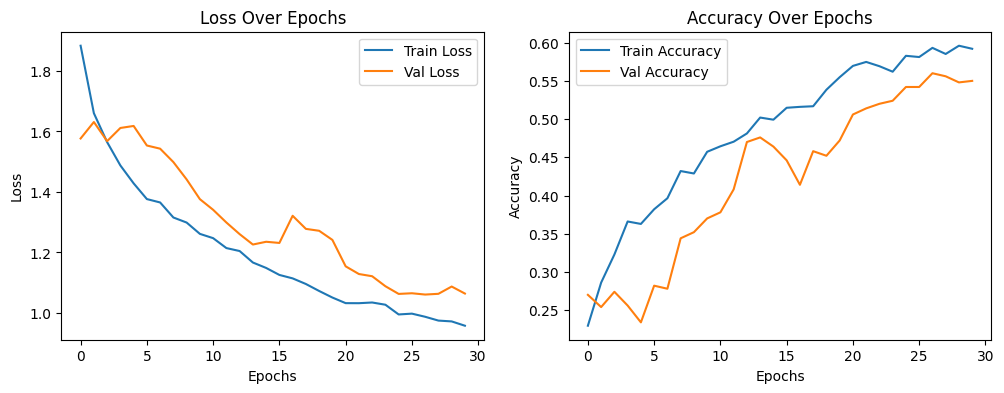

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.5982 - loss: 0.9936
Test Accuracy: 0.5580
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 747ms/step
              precision    recall  f1-score   support

           0       0.44      0.69      0.54       100
           1       0.51      0.57      0.54       100
           2       0.47      0.27      0.34       100
           3       0.69      0.66      0.67       100
           4       0.78      0.60      0.68       100

    accuracy                           0.56       500
   macro avg       0.58      0.56      0.55       500
weighted avg       0.58      0.56      0.55       500



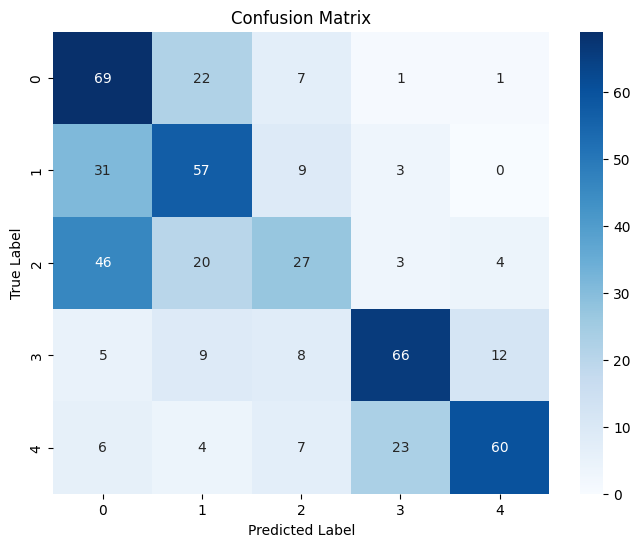

In [2]:
import kagglehub
import os
import random
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob  # Import glob for file handling

# Download latest version
data_path = kagglehub.dataset_download("kushagratandon12/diabetic-retinopathy-balanced")

# Define directories
train_dir = "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train"
val_dir = "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val"
test_dir = "/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/test"

# Function to reduce dataset size
def reduce_dataset(source_dir, target_dir, samples_per_class=500):
    os.makedirs(target_dir, exist_ok=True)
    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        target_category_path = os.path.join(target_dir, category)
        os.makedirs(target_category_path, exist_ok=True)
        
        image_files = glob(os.path.join(category_path, "*.*"))  # Filter only image files
        selected_files = random.sample(image_files, min(samples_per_class, len(image_files)))
        
        for file in selected_files:
            shutil.copy(file, os.path.join(target_category_path, os.path.basename(file)))

# Reduce dataset
reduce_dataset(train_dir, "reduced_train", samples_per_class=500)
reduce_dataset(val_dir, "reduced_val", samples_per_class=100)
reduce_dataset(test_dir, "reduced_test", samples_per_class=100)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load datasets
train_generator = train_datagen.flow_from_directory("reduced_train", target_size=(224, 224), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory("reduced_val", target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory("reduced_test", target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

# Model definition using ResNet152
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-30:]:  # Unfreeze last 30 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=30, 
    callbacks=[lr_scheduler, early_stopping]
)

# Visualize training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

plot_training_history(history)

# Save model
model.save("diabetic_retinopathy_model_resnet152.h5")

# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions and classification metrics
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification report
class_labels = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [66]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image

# Path to your test image
img_path = "/kaggle/working/reduced_test/0/1029_left.jpeg"

# Load image and preprocess it
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input size
img_array = image.img_to_array(img)  # Convert to NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize (same as training)


In [67]:
# Get predictions
predictions = model.predict(img_array)

# Get the class with highest probability
predicted_class = np.argmax(predictions, axis=1)[0]
confidence = np.max(predictions)  # Confidence score

# Get class labels (if available from train_generator)
class_labels = {v: k for k, v in train_generator.class_indices.items()}  # Reverse dictionary
predicted_label = class_labels[predicted_class]

print(f"Predicted Class: {predicted_label} (Confidence: {confidence:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Class: 0 (Confidence: 0.49)


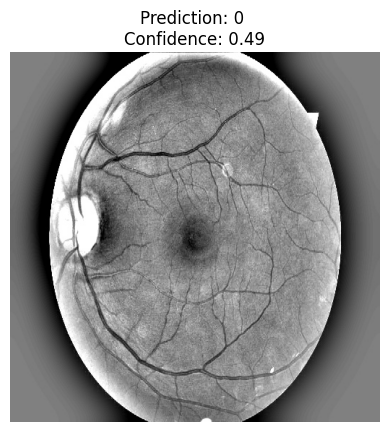

In [68]:
import matplotlib.pyplot as plt

# Show the image with prediction
plt.imshow(cv2.imread(img_path)[..., ::-1])  # Convert BGR to RGB for correct display
plt.axis("off")
plt.title(f"Prediction: {predicted_label} \nConfidence: {confidence:.2f}")
plt.show()
